Calculation of best-fit linear filters predicting DAN activity from behavior.

In [1]:
%reset -f
%matplotlib inline
from itertools import product as c_product
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model

from disp import set_font_size
from lin_fit import fit_h


# EXPT = 'ASENSORY_AZ'
# EXPT = 'CL_360_LOWFLOW_ACV'
EXPT = 'CL_180_HighFlow_ACV'

MVNG_ONLY = True
T_WDW = [-4.5, 4.5]  # must be symmetric to ensure correct convolution
TRUNCATE = 5  # num timepoints to truncate for edge effects

TARGS = ['G2', 'G3', 'G4', 'G5']
SRCS = ['Motion', 'ForVel', 'AngVel', 'AbsAngVel']
DT = 0.1
T_WDW_TR = [DT * (int(T_WDW[0]/DT) + TRUNCATE), DT * (int(T_WDW[1]/DT) - TRUNCATE)]

DATA_DIR = os.path.join('data', EXPT)
SAVE_DIR = os.path.join('data', '_RESULTS', 'DAN_FROM_BEHAV_FILTERS')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Load data and normalize/mask

In [2]:
if EXPT == 'ASENSORY_AZ':
    base = 'BigMAT.csv'
    mvng = 'Moving_Bouts.csv'
    mvng_cols = ['T1', 'T2']
else:
    base = 'clean.csv'
    mvng = 'moving.csv'
    mvng_cols = ['Start', 'Stop']
    
data_u = {}  # unnormalized data
data_n = {}  # normalized data

for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        # load data
        data_u_ = pd.read_csv(os.path.join(trial_path, base))
        
        # select relevant columns
        data_u_ = data_u_[['Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'Motion', 'ForVel', 'AngVel']]
        data_u_['AbsAngVel'] = np.abs(data_u_['AngVel'])
        data_u_ = data_u_.rename(columns={'G2_avg': 'G2', 'G3_avg': 'G3', 'G4_avg': 'G4', 'G5_avg': 'G5'})
        
        # subsample data if MVNG_ONLY is True
        if MVNG_ONLY:
            t_mask = np.zeros(len(data_u_), dtype=bool)
            
            if not os.path.exists(os.path.join(trial_path, mvng)):
                continue
                
            df_mvng = pd.read_csv(os.path.join(trial_path, mvng))
            
            for start, stop in zip(df_mvng[mvng_cols[0]], df_mvng[mvng_cols[1]]):
                t_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
                
            # TODO: create t_mask by opening moving bouts file
            data_u_[~t_mask] = np.nan
        
        data_u[trial] = data_u_
        
        # normalize data
        data_n_ = data_u_.copy()
        data_n_ -= data_n_.mean()
        data_n_ /= data_n_.std()
        
        # replace normalized time column with original time column
        data_n_['Time'] = data_u_['Time']
        
        data_n[trial] = data_n_

# Fit trial-by-trial filters

In [3]:
# create initial filter dataframes
t_h = np.arange(*T_WDW, DT)
df_blank = pd.DataFrame(np.nan, index=list(data_n), columns=t_h[TRUNCATE:-TRUNCATE]).rename_axis('TRIAL')

filters = {'{}_FROM_{}'.format(targ, src.upper()): df_blank.copy() for targ, src in list(c_product(TARGS, SRCS))}

wdws_d = [None, None]
wdws_d[0] = int(round(T_WDW[0]/DT))
wdws_d[1] = wdws_d[0] + int(len(t_h))

# loop over trials
for trial, data_n_ in data_n.items():
    # loop over srcs
    for src in SRCS:
        # loop over targs
        for targ in TARGS:
            # compute filter
            xs = {src: np.array(data_n_[src])}
            y = np.array(data_n_[targ])
            
            hs, icpt = fit_h(xs, y, {src: wdws_d}, [src], 'built-in', params={'model': linear_model.LinearRegression})
            
            # store filter
            filters['{}_FROM_{}'.format(targ, src.upper())].loc[trial] = hs[src][TRUNCATE:-TRUNCATE]

# save all filters
for k, df_save in filters.items():
    if MVNG_ONLY:
        sfx = '{}_{}_T_WDW_{}_{}_MVNG_ONLY.csv'.format(EXPT, k, *T_WDW_TR)
    else:
        sfx = '{}_{}_T_WDW_{}_{}.csv'.format(EXPT, k, *T_WDW_TR)

    df_save.to_csv(os.path.join(SAVE_DIR, sfx))

Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough valid data points.
Not enough

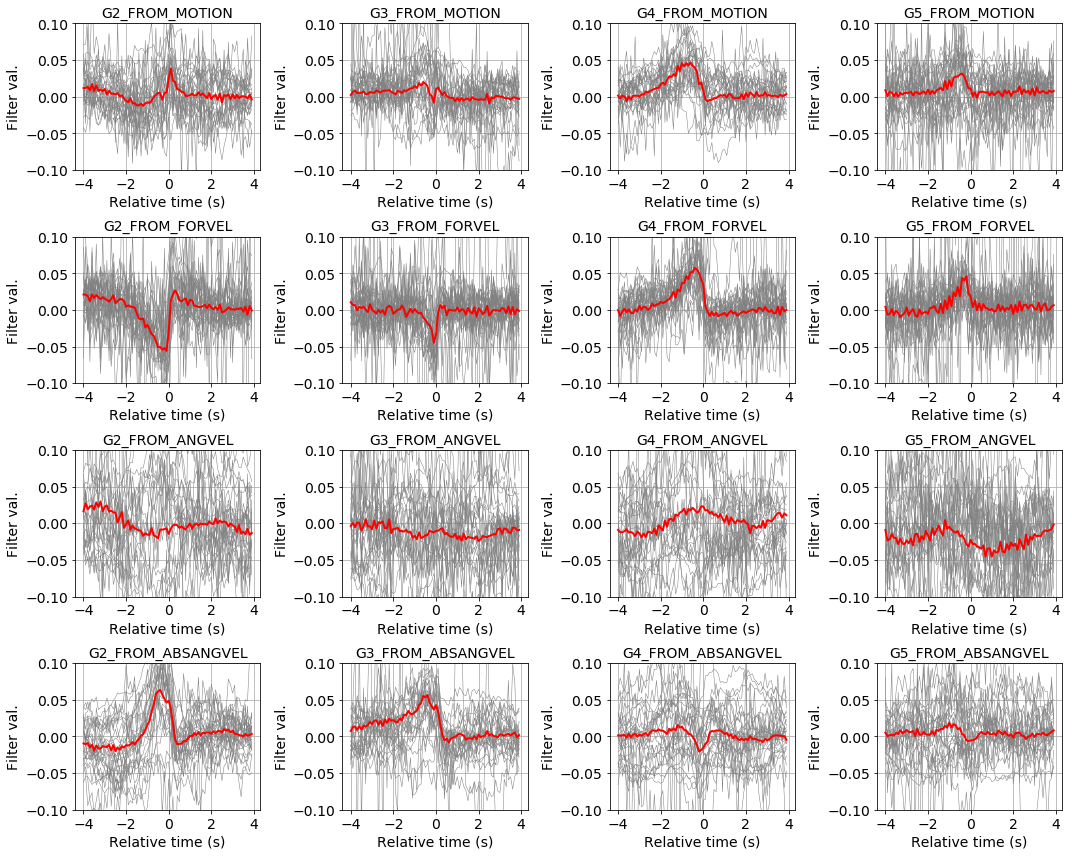

In [4]:
# plot filters
y_lim = (-.1, .1)
n_xmpls = 30

fig, axs = plt.subplots(len(SRCS), len(TARGS), figsize=(15, 3*len(SRCS)), tight_layout=True)

for src, ax_row in zip(SRCS, axs):
    for targ, ax in zip(TARGS, ax_row):
        k = '{}_FROM_{}'.format(targ, src.upper())
        
        if MVNG_ONLY:
            sfx = '{}_{}_T_WDW_{}_{}_MVNG_ONLY.csv'.format(EXPT, k, *T_WDW_TR)
        else:
            sfx = '{}_{}_T_WDW_{}_{}.csv'.format(EXPT, k, *T_WDW_TR)

        df = pd.read_csv(os.path.join(SAVE_DIR, sfx), index_col=0)
        
        # random trials
        ax.plot(t_h[TRUNCATE:-TRUNCATE], np.array(df.sample(n_xmpls)).T, lw=.5, color='gray')
        
        # mean
        ax.plot(t_h[TRUNCATE:-TRUNCATE], df.mean(), lw=2, color='r')
        
        ax.set_ylim(y_lim)
        
        ax.set_xlabel('Relative time (s)')
        ax.set_ylabel('Filter val.')
        ax.set_title(k)
        
        ax.grid()
        set_font_size(ax, 14)
    
if MVNG_ONLY:
    fig.savefig(os.path.join(SAVE_DIR, '{}_T_WDW_{}_{}_MVNG_ONLY.pdf'.format(EXPT, *T_WDW_TR)))
else:
    fig.savefig(os.path.join(SAVE_DIR, '{}_T_WDW_{}_{}.pdf'.format(EXPT, *T_WDW_TR)))